This notebook will: 

1. Drop the 'content' column for dataset 1.
2. Engineer other features (url profanity score, top level domain encodings)
3. Train different classification models: decision tree, random forest, gradient boosting, logistic regression
4. Save the best model to disk

In [14]:
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 09 11:40:11 2021
    Build the model by following this notebook:
@author: hatzi
"""

import nltk
import string
import re
import sklearn
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy import stats
import nltk 
nltk.download('stopwords') #<---uncomment if you haven't downloaded the stopwords library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set working directory 
folder = r'C:\Users\hatzi\Documents\SUTD\Systems Security Project\Datasets\Dataset of Malicious and Benign Webpages'
os.chdir(folder)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hatzi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Load training dataset. Will take some time as dataset is 2GB
df_train = pd.read_csv('Webpages_Classification_train_data.csv')

# Drop content column as there is a seperate NLP model for it
df_train = df_train.drop(['Unnamed: 0', 'content'], axis=1)
df_train.columns

Index(['url', 'url_len', 'ip_add', 'geo_loc', 'tld', 'who_is', 'https',
       'js_len', 'js_obf_len', 'label'],
      dtype='object')

In [9]:
df_train.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,label
0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,good
1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,good
2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,good
3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,bad
4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,good


In [10]:
df_train.sort_values(by=['url_len']).tail()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,label
391034,http://www.drugdigest.org/wps/portal/!ut/p/c0/...,624,93.69.163.42,Italy,org,complete,yes,0.0,0.0,good
677514,http://www.drugdigest.org/wps/portal/!ut/p/c0/...,628,186.24.149.197,Venezuela,org,complete,no,101.0,0.0,good
340683,http://www.drugdigest.org/wps/portal/!ut/p/c0/...,644,54.75.74.161,Ireland,org,complete,yes,89.0,0.0,good
300502,http://www.drugdigest.org/wps/portal/!ut/p/c0/...,648,39.208.168.21,Indonesia,org,complete,yes,78.5,0.0,good
235778,http://pqasb.pqarchiver.com/sptimes/main/doc/0...,721,151.133.89.114,United Kingdom,com,complete,no,102.0,0.0,good


#### Engineer url based features


In [11]:
from urllib.parse import urlparse
from tld import get_tld

# Function for cleaning the URL text before calling the profanity check 
def clean_url(url):
    url_text=""
    try:
        domain = get_tld(url, as_object=True)
        domain = get_tld(url, as_object=True)
        url_parsed = urlparse(url)
        url_text= url_parsed.netloc.replace(domain.tld," ").replace('www',' ') +" "+ url_parsed.path+" "+url_parsed.params+" "+url_parsed.query+" "+url_parsed.fragment
        url_text = url_text.translate(str.maketrans({'?':' ','\\':' ','.':' ',';':' ','/':' ','\'':' '}))
        url_text.strip(' ')
        url_text.lower()
    except:
        url_text = url_text.translate(str.maketrans({'?':' ','\\':' ','.':' ',';':' ','/':' ','\'':' '}))
        url_text.strip(' ')
    return url_text

df_train['original_url'] = df_train['url']
df_train['url'] = df_train['url'].map(clean_url)

df_train.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,label,original_url
0,members tripod russiastation,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,good,http://members.tripod.com/russiastation/
1,ddj cpp 184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,good,http://www.ddj.com/cpp/184403822
2,naef-usa,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,good,http://www.naef-usa.com/
3,ff-b2b,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,bad,http://www.ff-b2b.de/
4,us imdb title tt0176269,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,good,http://us.imdb.com/title/tt0176269/


In [12]:
df_train.sort_values(by=['url_len']).tail()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,label,original_url
391034,drugdigest wps portal !ut p c0 dy5ndoiwei...,624,93.69.163.42,Italy,org,complete,yes,0.0,0.0,good,http://www.drugdigest.org/wps/portal/!ut/p/c0/...
677514,drugdigest wps portal !ut p c0 dy5ndoiwei...,628,186.24.149.197,Venezuela,org,complete,no,101.0,0.0,good,http://www.drugdigest.org/wps/portal/!ut/p/c0/...
340683,drugdigest wps portal !ut p c0 dy5bdoiwee...,644,54.75.74.161,Ireland,org,complete,yes,89.0,0.0,good,http://www.drugdigest.org/wps/portal/!ut/p/c0/...
300502,drugdigest wps portal !ut p c0 dy7bdoiwdi...,648,39.208.168.21,Indonesia,org,complete,yes,78.5,0.0,good,http://www.drugdigest.org/wps/portal/!ut/p/c0/...
235778,pqasb pqarchiver sptimes main doc 000000057...,721,151.133.89.114,United Kingdom,com,complete,no,102.0,0.0,good,http://pqasb.pqarchiver.com/sptimes/main/doc/0...


In [13]:
from profanity_check import predict, predict_prob
df_train['url_profanity_score'] = predict_prob(df_train['url'].astype(str).to_numpy())
df_train.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,label,original_url,url_profanity_score
0,members tripod russiastation,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,good,http://members.tripod.com/russiastation/,0.087409
1,ddj cpp 184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,good,http://www.ddj.com/cpp/184403822,0.046085
2,naef-usa,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,good,http://www.naef-usa.com/,0.279107
3,ff-b2b,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,bad,http://www.ff-b2b.de/,0.045103
4,us imdb title tt0176269,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,good,http://us.imdb.com/title/tt0176269/,0.014901


In [15]:
# See URLs with high profanity score
df_train[df_train['url_profanity_score'] > 0.8].head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,label,original_url,url_profanity_score
1619,planet-pussy,28,142.196.138.247,United States,com,incomplete,no,395.1,217.305,bad,http://www.planet-pussy.com/,0.998407
2123,sexo-gratis anal-hardcore-sex-pics,50,34.116.26.105,United States,com,complete,no,336.6,0.000,bad,http://www.sexo-gratis.anal-hardcore-sex-pics....,0.827001
2591,rotten library bio misc dick-wolf,49,122.85.113.65,China,com,complete,yes,142.5,0.000,good,http://www.rotten.com/library/bio/misc/dick-wolf/,0.841259
3431,xxxsex anal-hardcore-sex-pics,45,78.183.245.58,Turkey,com,incomplete,no,499.5,264.735,bad,http://www.xxxsex.anal-hardcore-sex-pics.com/,0.827001
4757,free-nude-pussy-pictures eating-pussy,53,42.76.71.57,Taiwan,com,incomplete,no,371.7,230.454,bad,http://www.free-nude-pussy-pictures.com/eating...,0.998809


### Drop URL column now

In [16]:
df_train = df_train.drop(['url'], axis=1)
df_train.columns

Index(['url_len', 'ip_add', 'geo_loc', 'tld', 'who_is', 'https', 'js_len',
       'js_obf_len', 'label', 'original_url', 'url_profanity_score'],
      dtype='object')

#### Convert labels to binary labels

In [17]:
df_train['label'].replace(to_replace ="good", value = 1, inplace = True)
df_train['label'].replace(to_replace ="bad", value = 0, inplace = True)

Convert IP addresses to split. Eg 192.168.2.254 -> '192', '168', '2', '254'. 
Split IP addresses is better than binary or one-hot encoding. See https://hammer.purdue.edu/articles/thesis/Encoding_IP_Address_as_a_Feature_for_Network_Intrusion_Detection/11307287

In [18]:
df_train['ip_split_1'], df_train['ip_split_2'], df_train['ip_split_3'], df_train['ip_split_4'] = '','','',''

for index, row in df_train.iterrows():
    ip_string = row['ip_add']
    ip_split_1 = ip_string.split('.')[0]
    ip_split_2 = ip_string.split('.')[1]
    ip_split_3 = ip_string.split('.')[2]
    ip_split_4 = ip_string.split('.')[3]
    
    # print(ip_split_1, ip_split_2, ip_split_3, ip_split_4)
    df_train.at[index, 'ip_split_1'] = ip_split_1
    df_train.at[index, 'ip_split_2'] = ip_split_2
    df_train.at[index, 'ip_split_3'] = ip_split_3
    df_train.at[index, 'ip_split_4'] = ip_split_4

In [19]:
df_train[["ip_split_1", "ip_split_2", "ip_split_3", "ip_split_4"]] = df_train[["ip_split_1", "ip_split_2", "ip_split_3", "ip_split_4"]].apply(pd.to_numeric)
df_train.head()

,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,label,original_url,url_profanity_score,ip_split_1,ip_split_2,ip_split_3,ip_split_4
0,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,1,http://members.tripod.com/russiastation/,0.087409,42,77,221,155
1,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,1,http://www.ddj.com/cpp/184403822,0.046085,3,211,202,180
2,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,1,http://www.naef-usa.com/,0.279107,24,232,54,41
3,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,0,http://www.ff-b2b.de/,0.045103,147,22,38,45
4,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,1,http://us.imdb.com/title/tt0176269/,0.014901,205,30,239,85


In [20]:
df_train = df_train.drop(['ip_add'], axis=1)
df_train.columns

Index(['url_len', 'geo_loc', 'tld', 'who_is', 'https', 'js_len', 'js_obf_len',
       'label', 'original_url', 'url_profanity_score', 'ip_split_1',
       'ip_split_2', 'ip_split_3', 'ip_split_4'],
      dtype='object')

### Clean the rest of the categorical columns: geo_loc,	tld,	who_is,	https

In [21]:
# Convert http first as it is binary 
df_train['https'].replace(to_replace ="yes", value = 1, inplace = True)
df_train['https'].replace(to_replace ="no", value = 0, inplace = True)

In [22]:
# Convert who_is next as it is also binary 
df_train['who_is'].replace(to_replace ="complete", value = 1, inplace = True)
df_train['who_is'].replace(to_replace ="incomplete", value = 0, inplace = True)

In [23]:
# Use ordinal encoding for the other 2 categorical variables
df_train['geo_loc'] = OrdinalEncoder().fit_transform(df_train.geo_loc.values.reshape(-1,1))
df_train['tld'] = OrdinalEncoder().fit_transform(df_train.tld.values.reshape(-1,1))

In [15]:
# Save geo encoder
import pickle
import numpy as np
geo_enc = OrdinalEncoder()
geo_enc.fit(df_train.geo_loc.values.reshape(-1,1))
geo_enc.transform(df_train.geo_loc.values.reshape(-1,1))
output = open('rf_geo_loc_encoder.pkl', 'wb')
pickle.dump(geo_enc, output)
output.close()

# Save tld encoder
tld_enc = OrdinalEncoder()
tld_enc.fit(df_train.tld.values.reshape(-1,1))
output = open('rf_tld_encoder.pkl', 'wb')
pickle.dump(tld_enc, output)
output.close()

In [16]:
tld_enc.categories_

[array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.243e+03, 1.244e+03,
        1.245e+03])]

In [17]:
df_train.geo_loc.values.reshape(-1,1)

array([[205.],
       [222.],
       [  9.],
       ...,
       [ 45.],
       [222.],
       [222.]])

In [18]:
a = df_train['who_is'].unique()
print(sorted(a))

[0, 1]


In [19]:
one_hot_data = pd.get_dummies(df_train[['geo_loc','tld']])
one_hot_data.columns

Index(['geo_loc', 'tld'], dtype='object')

In [20]:
one_hot_data.head()

,geo_loc,tld
0,205.0,195.0
1,222.0,195.0
2,9.0,195.0
3,222.0,282.0
4,222.0,195.0


### Time to train our model with our features

In [24]:
df_train.head()

,url_len,geo_loc,tld,who_is,https,js_len,js_obf_len,label,original_url,url_profanity_score,ip_split_1,ip_split_2,ip_split_3,ip_split_4
0,40,205.0,195.0,1,1,58.0,0.0,1,http://members.tripod.com/russiastation/,0.087409,42,77,221,155
1,32,222.0,195.0,1,1,52.5,0.0,1,http://www.ddj.com/cpp/184403822,0.046085,3,211,202,180
2,24,9.0,195.0,1,1,103.5,0.0,1,http://www.naef-usa.com/,0.279107,24,232,54,41
3,21,222.0,282.0,0,0,720.0,532.8,0,http://www.ff-b2b.de/,0.045103,147,22,38,45
4,35,222.0,195.0,1,1,46.5,0.0,1,http://us.imdb.com/title/tt0176269/,0.014901,205,30,239,85


In [25]:
df_train.dtypes

url_len                  int64
geo_loc                float64
tld                    float64
who_is                   int64
https                    int64
js_len                 float64
js_obf_len             float64
label                    int64
original_url            object
url_profanity_score    float64
ip_split_1               int64
ip_split_2               int64
ip_split_3               int64
ip_split_4               int64
dtype: object

In [26]:
# Note that test set is in the other csv file
X_train = df_train[['url_len', 'ip_split_1', 'ip_split_2', 'ip_split_3', 'ip_split_4', 
             'geo_loc', 'tld', 'who_is', 'js_len', 'js_obf_len', 'https', 'url_profanity_score']]
y_train = df_train.label

### Load test data and prepare for use to get test metrics

In [28]:
df_test = pd.read_csv('Webpages_Classification_test_data.csv')
df_test = df_test.drop(['Unnamed: 0', 'content'], axis=1)
df_test['url'] = df_test['url'].map(clean_url)
df_test['url_profanity_score'] = predict_prob(df_test['url'].astype(str).to_numpy())
df_test = df_test.drop(['url'], axis=1)
df_test['label'].replace(to_replace ="good", value = 1, inplace = True)
df_test['label'].replace(to_replace ="bad", value = 0, inplace = True)
df_test['ip_split_1'], df_test['ip_split_2'], df_test['ip_split_3'], df_test['ip_split_4'] = '','','',''
for index, row in df_test.iterrows():
    ip_string = row['ip_add']
    ip_split_1 = ip_string.split('.')[0]
    ip_split_2 = ip_string.split('.')[1]
    ip_split_3 = ip_string.split('.')[2]
    ip_split_4 = ip_string.split('.')[3]
    df_test.at[index, 'ip_split_1'] = ip_split_1
    df_test.at[index, 'ip_split_2'] = ip_split_2
    df_test.at[index, 'ip_split_3'] = ip_split_3
    df_test.at[index, 'ip_split_4'] = ip_split_4
df_test['https'].replace(to_replace ="yes", value = 1, inplace = True)
df_test['https'].replace(to_replace ="no", value = 0, inplace = True)
df_test['who_is'].replace(to_replace ="complete", value = 1, inplace = True)
df_test['who_is'].replace(to_replace ="incomplete", value = 0, inplace = True)
df_test['geo_loc'] = OrdinalEncoder().fit_transform(df_test.geo_loc.values.reshape(-1,1))
df_test['tld'] = OrdinalEncoder().fit_transform(df_test.tld.values.reshape(-1,1))
df_test = df_test.drop(['ip_add'], axis=1)
df_test[["ip_split_1", "ip_split_2", "ip_split_3", "ip_split_4"]] = df_test[["ip_split_1", "ip_split_2", "ip_split_3", "ip_split_4"]].apply(pd.to_numeric)

In [29]:
# Extract test set from df_test
X_test = df_test[['url_len', 'ip_split_1', 'ip_split_2', 'ip_split_3', 'ip_split_4', 
             'geo_loc', 'tld', 'who_is', 'js_len', 'js_obf_len', 'https', 'url_profanity_score']]
y_test = df_test.label

### Train decision tree model

In [54]:
# Train model
# Decision Tree

param_grid=[{"criterion":["gini", "entropy"],
             "splitter":["best", "random"]}]
decision_tree_grid=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),param_grid=param_grid,cv=5)
decision_tree_grid.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'splitter': ['best', 'random']}])

In [27]:
param_grid=[{"criterion":["entropy"],
             "splitter":["best"]}]
decision_tree_grid=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),param_grid=param_grid,cv=5)
decision_tree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'criterion': ['entropy'], 'splitter': ['best']}])

In [55]:
print('Decision tree best params: ', decision_tree_grid.best_params_)

Decision tree best params:  {'criterion': 'entropy', 'splitter': 'best'}


In [30]:
print('Decision tree test accuracy: ', decision_tree_grid.score(X_test,y_test))

Decision tree test accuracy:  0.998488674730752


## Train Gradient Boosting Classifier

In [31]:
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression

# XBB grid search
xgb_model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
params = {
        'min_child_weight': [1],
        'gamma': [0.5],
        'subsample': [1.0],
        'max_depth': [5]
        }
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=params, cv=5)
xgb_grid.fit(X_train,y_train)

print('\n All results:')
print(xgb_grid.cv_results_)
print('\n Best estimator:')
print(xgb_grid.best_estimator_)
print('\n Best hyperparameters:')
print(xgb_grid.best_params_)

# Get xgb test score
print('XGB test accuracy: ', xgb_grid.score(X_test,y_test))

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:12:16] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:12:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:06] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:17:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:22:08] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:22:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:31:46] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:31:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:37:21] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:37:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:54] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:56:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 All results:
{'mean_fit_time': array([521.06897645]), 'std_fit_time': array([309.49768514]), 'mean_score_time': array([1.94962845]), 'std_score_time': array([2.28822253]), 'param_gamma': masked_array(data=[0.5],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[5],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_min_c

In [34]:
# Logistic regression grid search
import numpy as np
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\hatzi\anacon

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\hatzi\anacon

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\hatzi\anacon

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\hatzi\anacon

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\hatzi\anacon

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hatzi\anaco

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\hatzi\anacon

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\hatzi\anacon

C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'penalty': 'l2'}
accuracy : 0.9976933333333333


C:\Users\hatzi\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Train logistic regression model

In [35]:
# Logistic regression test score
print('Logistic regression test accuracy: ', logreg_cv.score(X_test,y_test))

Logistic regression test accuracy:  0.9977537341062183


### Train random forest model

In [67]:
# Random Forest
param_grid=[{"n_estimators":[x for x in range(10, 120, 10)],
             "criterion":["gini", "entropy"]}]
forest_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=param_grid,cv=5)
forest_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                           100, 110]}])

In [68]:
print('Random forest best params: ', forest_grid.best_params_)

Random forest best params:  {'criterion': 'entropy', 'n_estimators': 110}


In [69]:
print('Random forest accuracy: ', forest_grid.score(X_test,y_test))

Random forest accuracy:  0.9990467875358491


In [65]:
param_grid=[{"n_estimators":[110],
             "criterion":["entropy"]}]
forest_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=param_grid,cv=5)
forest_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['entropy'], 'n_estimators': [110]}])

In [66]:
print('Random forest accuracy: ', forest_grid.score(X_test,y_test))

Random forest accuracy:  0.9990467875358491


### Can conclude that random forest is the best model

In [68]:
# Test prediction on a malicious label ie label == 0
test_label_0 = df_test[df_test['label'] == 0]
test_label_0_pred = df_test.label
test_label_0 = test_label_0[['url_len', 'ip_split_1', 'ip_split_2', 'ip_split_3', 'ip_split_4', 
             'geo_loc', 'tld', 'who_is', 'js_len', 'js_obf_len', 'https', 'url_profanity_score']]

In [72]:
forest_grid.predict(test_label_0)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [71]:
df_test[df_test['label'] == 0].head()

,url_len,geo_loc,tld,who_is,https,js_len,js_obf_len,label,url_profanity_score,ip_split_1,ip_split_2,ip_split_3,ip_split_4
93,29,206.0,136.0,0,0,356.4,178.200,0,0.046085,75,165,190,102
266,28,180.0,136.0,0,0,808.2,363.690,0,0.090648,61,83,239,62
326,29,95.0,201.0,0,0,779.4,319.554,0,0.046085,87,43,230,193
400,22,101.0,412.0,0,0,365.4,193.662,0,0.051925,163,216,178,149
422,29,206.0,136.0,0,0,392.4,200.124,0,0.046085,75,195,91,191


In [70]:
# Save model to disk
import joblib

#save your model or results
joblib.dump(forest_grid, 'random_forest.pkl')

['random_forest.pkl']

In [28]:
#load your model for further usage
import joblib
loaded_model = joblib.load("random_forest.pkl")

In [29]:
type(loaded_model)

sklearn.model_selection._search.GridSearchCV

In [30]:
# Get feature importance of random forest model
rf_model = loaded_model.best_estimator_
type(rf_model)

sklearn.ensemble._forest.RandomForestClassifier

<AxesSubplot:>

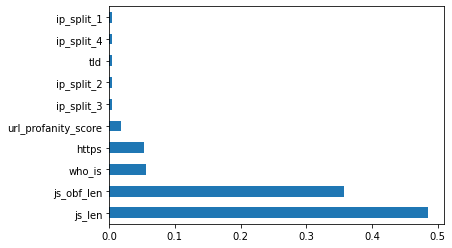

In [34]:
# Print random forest feature importance
import matplotlib.pyplot as plt
columns = X_train.columns

feat_importances = pd.Series(rf_model.feature_importances_, index=columns)
feat_importances.nlargest(10).plot(kind='barh')

In [37]:
# Check for class imbalance

total_rows = len(df_test) + len(df_train)
total_0 = len(df_test[df_test['label'] == 0]) + len(df_train[df_train['label'] == 0])
total_1 = len(df_test[df_test['label'] == 1]) + len(df_train[df_train['label'] == 1])

print('Total rows:', total_rows)
print('Label 0 percentage:', total_0 / total_rows, 'Label 0 counts:', total_0)
print('Label 1 percentage:', total_1 / total_rows, 'Label 1 counts:', total_1)

Total rows: 1561934
Label 0 percentage: 0.022609790170391324 Label 0 counts: 35315
Label 1 percentage: 0.9773902098296087 Label 1 counts: 1526619


### Do a test prediction

In [35]:
test_data = X_test.head()

In [107]:
test_data

,url_len,ip_split_1,ip_split_2,ip_split_3,ip_split_4,geo_loc,tld,who_is,js_len,js_obf_len,https,url_profanity_score
0,36,175,67,214,68,41.0,136.0,1,38.5,0.0,1,0.046085
1,32,188,120,171,121,187.0,136.0,0,187.0,0.0,1,0.046085
2,27,193,51,170,1,67.0,136.0,1,31.0,0.0,1,0.046085
3,56,13,237,35,44,11.0,276.0,1,152.0,0.0,1,0.077642
4,40,220,193,62,89,41.0,136.0,1,150.0,0.0,1,0.025919


In [108]:
loaded_model.predict(test_data)

array([1, 1, 1, 1, 1], dtype=int64)

In [115]:
values = {
    'url_len': [36], 'ip_split_1': [175], 'ip_split_2': [32], 'ip_split_3': [214], 'ip_split_4': [68], 
    'geo_loc': [41.0], 'tld': [136.0], 'who_is': [1], 'js_len': [38.5], 'js_obf_len': [0.0], 
    'https': [1], 'url_profanity_score': [0.987]
}
test_data = pd.DataFrame.from_dict(values)
test_data

,url_len,ip_split_1,ip_split_2,ip_split_3,ip_split_4,geo_loc,tld,who_is,js_len,js_obf_len,https,url_profanity_score
0,36,175,32,214,68,41.0,136.0,1,38.5,0.0,1,0.987


In [116]:
loaded_model.predict(test_data)

array([1], dtype=int64)

In [118]:
loaded_model.predict_proba(test_data)

array([[0.02727273, 0.97272727]])